In [1]:
from scipy.io import wavfile
from fairseq import checkpoint_utils
import torchaudio
from lib.audio import load_audio
from lib.infer_pack.models import (
    SynthesizerTrnMs256NSFsid,
    SynthesizerTrnMs256NSFsid_nono,
    SynthesizerTrnMs768NSFsid,
    SynthesizerTrnMs768NSFsid_nono,
)
from vc_infer_pipeline import VC
from multiprocessing import cpu_count
import numpy as np
import torch
import sys
import glob
import argparse
import os
import sys
import pdb
import torch

now_dir = os.getcwd()
sys.path.append(now_dir)

####
# USAGE
#
# In your Terminal or CMD or whatever
# python infer_cli.py [TRANSPOSE_VALUE] "[INPUT_PATH]" "[OUTPUT_PATH]" "[MODEL_PATH]" "[INDEX_FILE_PATH]" "[INFERENCE_DEVICE]" "[METHOD]"

using_cli = False
device = "cuda:0" if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
is_half = False

    
if device == 'mps':
    # 设置环境变量 PYTORCH_ENABLE_MPS_FALLBACK=1
    os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

# 只在jupyter notebook中运行
from IPython import get_ipython
if get_ipython() is not None:
    %set_env PYTORCH_ENABLE_MPS_FALLBACK=1
    pass

class Config:
    def __init__(self, device, is_half):
        self.device = device
        self.is_half = is_half
        self.n_cpu = 0
        self.gpu_name = None
        self.gpu_mem = None
        self.x_pad, self.x_query, self.x_center, self.x_max = self.device_config()

    def device_config(self) -> tuple:
        if torch.cuda.is_available() and device != "cpu":
            i_device = int(self.device.split(":")[-1])
            self.gpu_name = torch.cuda.get_device_name(i_device)
            if (
                ("16" in self.gpu_name and "V100" not in self.gpu_name.upper())
                or "P40" in self.gpu_name.upper()
                or "1060" in self.gpu_name
                or "1070" in self.gpu_name
                or "1080" in self.gpu_name
            ):
                print("16系/10系显卡和P40强制单精度")
                self.is_half = False
                for config_file in ["32k.json", "40k.json", "48k.json"]:
                    with open(f"configs/{config_file}", "r") as f:
                        strr = f.read().replace("true", "false")
                    with open(f"configs/{config_file}", "w") as f:
                        f.write(strr)
                with open("trainset_preprocess_pipeline_print.py", "r") as f:
                    strr = f.read().replace("3.7", "3.0")
                with open("trainset_preprocess_pipeline_print.py", "w") as f:
                    f.write(strr)
            else:
                self.gpu_name = None
            self.gpu_mem = int(
                torch.cuda.get_device_properties(i_device).total_memory
                / 1024
                / 1024
                / 1024
                + 0.4
            )
            if self.gpu_mem <= 4:
                with open("trainset_preprocess_pipeline_print.py", "r") as f:
                    strr = f.read().replace("3.7", "3.0")
                with open("trainset_preprocess_pipeline_print.py", "w") as f:
                    f.write(strr)
        elif torch.backends.mps.is_available():
            print("没有发现支持的N卡, 使用MPS进行推理")
            self.device = "mps"
        else:
            print("没有发现支持的N卡, 使用CPU进行推理")
            self.device = "cpu"
            self.is_half = False

        if self.n_cpu == 0:
            self.n_cpu = cpu_count()

        if self.is_half:
            # 6G显存配置
            x_pad = 3
            x_query = 10
            x_center = 60
            x_max = 65
        else:
            # 5G显存配置
            x_pad = 1
            x_query = 6
            x_center = 38
            x_max = 41

        if self.gpu_mem != None and self.gpu_mem <= 4:
            x_pad = 1
            x_query = 5
            x_center = 30
            x_max = 32

        return x_pad, x_query, x_center, x_max


config = Config(device, is_half)
now_dir = os.getcwd()
sys.path.append(now_dir)

hubert_model = None


def load_hubert():
    global hubert_model
    models, _, _ = checkpoint_utils.load_model_ensemble_and_task(
        ["hubert_base.pt"],
        suffix="",
    )
    hubert_model = models[0]
    hubert_model = hubert_model.to(config.device)
    if config.is_half:
        hubert_model = hubert_model.half()
    else:
        hubert_model = hubert_model.float()
    hubert_model.eval()


def vc_single(
    sid=0,
    input_audio_path=None,
    f0_up_key=0,
    f0_file=None,
    f0_method="pm",
    file_index="",  # .index file
    file_index2="",
    # file_big_npy,
    index_rate=1.0,
    filter_radius=3,
    resample_sr=0,
    rms_mix_rate=0,
    model_path="",
    output_path="",
    protect=0.33,
    ret_audio=False
):
    # 打印每个参数
    print(f"sid: {sid}")
    print(f"f0_up_key: {f0_up_key}")
    print(f"f0_method: {f0_method}")
    print(f"file_index: {file_index}")
    print(f"file_index2: {file_index2}")
    print(f"index_rate: {index_rate}")
    print(f"filter_radius: {filter_radius}")
    print(f"resample_sr: {resample_sr}")
    print(f"rms_mix_rate: {rms_mix_rate}")
    print(f"protect: {protect}")
    
    global tgt_sr, net_g, vc, hubert_model, version
    get_vc(model_path)
    if input_audio_path is None:
        return "You need to upload an audio file", None

    f0_up_key = int(f0_up_key)
    if not input_audio_path.endswith(".npy"):
        audio = load_audio(input_audio_path, 16000)
    else:
        waveform = np.load(input_audio_path)
        # 重采样回16000
        import librosa
        audio = librosa.resample(waveform, orig_sr=24000, target_sr=16000)
        
    print(f"audio shape: {audio.shape}")
    audio_max = np.abs(audio).max() / 0.95

    if audio_max > 1:
        audio /= audio_max
    times = [0, 0, 0]

    if hubert_model == None:
        load_hubert()

    if_f0 = cpt.get("f0", 1)

    file_index = (
        (
            file_index.strip(" ")
            .strip('"')
            .strip("\n")
            .strip('"')
            .strip(" ")
            .replace("trained", "added")
        )
        if file_index != ""
        else file_index2
    )

    audio_opt = vc.pipeline(
        hubert_model,
        net_g,
        sid,
        audio,
        input_audio_path,
        times,
        f0_up_key,
        f0_method,
        file_index,
        # file_big_npy,
        index_rate,
        if_f0,
        filter_radius,
        tgt_sr,
        resample_sr,
        rms_mix_rate,
        version,
        f0_file=f0_file,
        protect=protect,
        ret_audio_opt=ret_audio,
    )
    if ret_audio:
        return audio_opt
    # audio_opt = audio_opt.astype(np.int32)  # convert to pcm_f32le
    wavfile.write(output_path, resample_sr, audio_opt)
    return "processed"


def get_vc(model_path):
    global n_spk, tgt_sr, net_g, vc, cpt, device, is_half, version
    print("loading pth %s" % model_path)
    cpt = torch.load(model_path, map_location="cpu")
    tgt_sr = cpt["config"][-1]
    cpt["config"][-3] = cpt["weight"]["emb_g.weight"].shape[0]  # n_spk
    if_f0 = cpt.get("f0", 1)
    version = cpt.get("version", "v1")
    if version == "v1":
        if if_f0 == 1:
            net_g = SynthesizerTrnMs256NSFsid(*cpt["config"], is_half=is_half)
        else:
            net_g = SynthesizerTrnMs256NSFsid_nono(*cpt["config"])
    elif version == "v2":
        if if_f0 == 1:
            net_g = SynthesizerTrnMs768NSFsid(*cpt["config"], is_half=is_half)
        else:
            net_g = SynthesizerTrnMs768NSFsid_nono(*cpt["config"])
    del net_g.enc_q
    print(net_g.load_state_dict(cpt["weight"], strict=False))
    net_g.eval().to(device)
    if is_half:
        net_g = net_g.half()
    else:
        net_g = net_g.float()
    vc = VC(tgt_sr, config)
    n_spk = cpt["config"][-3]
    # return {"visible": True,"maximum": n_spk, "__type__": "update"}



/Users/charslee/miniconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-20 20:26:29 | INFO | faiss.loader | Loading faiss.
2024-06-20 20:26:29 | INFO | faiss.loader | Successfully loaded faiss.


env: PYTORCH_ENABLE_MPS_FALLBACK=1
没有发现支持的N卡, 使用MPS进行推理


In [2]:
f0_up_key = 0
# input_path = "output.wav"
input_path = "uncompressed_output.npy"
output_path = "opt/record.wav"
model_path = "weights/three_moon_e20_s10000.pth"
file_index = ''
f0_method = 'rmvpe'
using_cli = True

# 获取换声后的音频信号
audio_opt = vc_single(
        sid=0,
        input_audio_path=input_path,
        f0_up_key=f0_up_key,
        f0_file=None,
        f0_method=f0_method,
        file_index=file_index,
        file_index2="",
        index_rate=1,
        filter_radius=3,
        resample_sr=24000,
        rms_mix_rate=1,
        model_path=model_path,
        output_path=output_path,
        ret_audio=True,
        protect = 0.5,  # 不开启撕裂，电音保护
    )
# 打印audio_opt 最大值和最小值
print(f"audio_opt max= {audio_opt.max()} and min = {audio_opt.min()}")

sid: 0
f0_up_key: 0
f0_method: rmvpe
file_index: 
file_index2: 
index_rate: 1
filter_radius: 3
resample_sr: 24000
rms_mix_rate: 1
protect: 0.5
loading pth weights/three_moon_e20_s10000.pth


/Users/charslee/miniconda3/envs/torch/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


gin_channels: 256 self.spk_embed_dim: 109
<All keys matched successfully>


2024-06-20 20:26:30 | INFO | fairseq.tasks.hubert_pretraining | current directory is /private/tmp/Retrieval-based-Voice-Conversion-WebUI
2024-06-20 20:26:30 | INFO | fairseq.tasks.hubert_pretraining | HubertPretrainingTask Config {'_name': 'hubert_pretraining', 'data': 'metadata', 'fine_tuning': False, 'labels': ['km'], 'label_dir': 'label', 'label_rate': 50.0, 'sample_rate': 16000, 'normalize': False, 'enable_padding': False, 'max_keep_size': None, 'max_sample_size': 250000, 'min_sample_size': 32000, 'single_target': False, 'random_crop': True, 'pad_audio': False}
2024-06-20 20:26:30 | INFO | fairseq.models.hubert.hubert | HubertModel Config: {'_name': 'hubert', 'label_rate': 50.0, 'extractor_mode': default, 'encoder_layers': 12, 'encoder_embed_dim': 768, 'encoder_ffn_embed_dim': 3072, 'encoder_attention_heads': 12, 'activation_fn': gelu, 'layer_type': transformer, 'dropout': 0.1, 'attention_dropout': 0.1, 'activation_dropout': 0.0, 'encoder_layerdrop': 0.05, 'dropout_input': 0.1, 'dr

audio shape: (110422,)


/Users/charslee/miniconda3/envs/torch/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Parameters of the 'pipeline' function:
sid: 0
audio: [-5.0958231e-05 -6.9872345e-05 -6.6835782e-05 ...  1.8133329e-05
  2.7920241e-05  0.0000000e+00]
input_audio_path: uncompressed_output.npy
times: [0, 0, 0]
f0_up_key: 0
f0_method: rmvpe
file_index: 
index_rate: 1
if_f0: 0
filter_radius: 3
tgt_sr: 40000
resample_sr: 24000
rms_mix_rate: 1
version: v2
protect: 0.5
f0_file: None
+---------------------------------------+


/Users/charslee/miniconda3/envs/torch/lib/python3.10/site-packages/fairseq/utils.py:744: UserWarning: MPS: nonzero op is supported natively starting from macOS 13.0. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Indexing.mm:283.)
  tensor[indices] = value
/Users/charslee/miniconda3/envs/torch/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:26: UserWarning: The operator 'aten::_weight_norm_interface' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  return _weight_norm(v, g, self.dim)
/Users/charslee/miniconda3/envs/torch/lib/python3.10/site-packages/torch/nn/functional.py:3981: UserWarning: MPS: passing scale factor to upsample ops is supported natively starting from macOS 13.0. 

audio_opt max= 0.835437536239624 and min = -0.6027973294258118


In [3]:
print(audio_opt)
from IPython.display import Audio
Audio(data=audio_opt,rate=24000)

[-1.5568100e-04 -2.1233881e-04 -2.2120489e-04 ... -1.8661990e-04
 -1.2952104e-04 -5.6025721e-05]


In [4]:
# 重新加载回mel频谱图
mel_spec = torchaudio.transforms.MelSpectrogram(
    sample_rate=24000,
    n_fft=1024,
    hop_length=256,
    n_mels=100,
    center=True,
    power=1,
)

def safe_log(x: torch.Tensor, clip_val: float = 1e-7) -> torch.Tensor:
    """
    Computes the element-wise logarithm of the input tensor with clipping to avoid near-zero values.

    Args:
        x (Tensor): Input tensor.
        clip_val (float, optional): Minimum value to clip the input tensor. Defaults to 1e-7.

    Returns:
        Tensor: Element-wise logarithm of the input tensor with clipping applied.
    """
    return torch.log(torch.clip(x, min=clip_val))

audio dtype: float32 and shape (165120,)
log_mel_spec shape: torch.Size([100, 646])


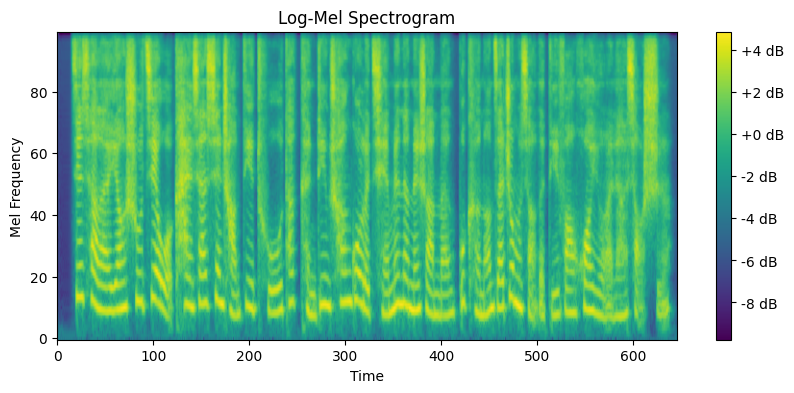

In [5]:
print(f"audio dtype: {audio_opt.dtype} and shape {audio_opt.shape}")
from matplotlib import pyplot as plt

# 可能需要进一步处理，比如取对数、缩放等，以便于可视化或后续处理
log_mel_spec = mel_spec(torch.from_numpy(audio_opt))
log_mel_spec = safe_log(log_mel_spec)
print(f"log_mel_spec shape: {log_mel_spec.shape}")

plt.figure(figsize=(10, 4))
plt.imshow(log_mel_spec, aspect='auto', origin='lower')
plt.title('Log-Mel Spectrogram')
plt.xlabel('Time')
plt.ylabel('Mel Frequency')
plt.colorbar(format='%+2.0f dB')
plt.show()

waveforme shape: torch.Size([1, 165632]) and smaplte rate: 24000
waveforme max: 0.5926513671875 and min: -0.498443603515625
audio mel spec shape: torch.Size([100, 648])


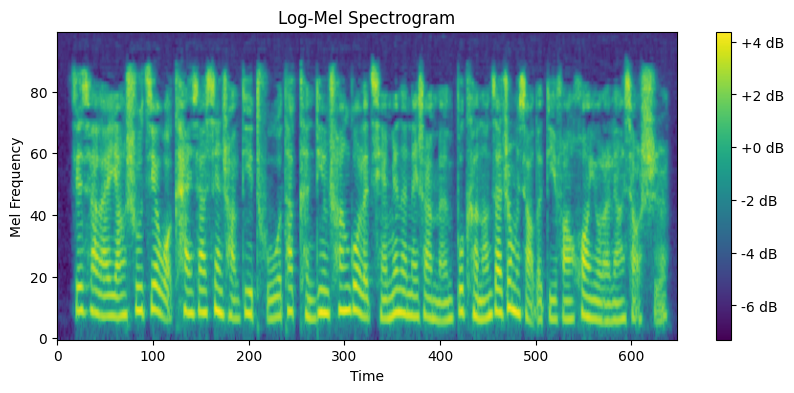

In [6]:
from matplotlib import pyplot as plt

input_audio_path = "output.wav"
waveforme,sr = torchaudio.load(input_audio_path)
print(f"waveforme shape: {waveforme.shape} and smaplte rate: {sr}")
Audio(input_audio_path, rate=sr)

# 打印waveforme 最大值和最小值
print(f"waveforme max: {waveforme.max()} and min: {waveforme.min()}")

audio_mel_spec = mel_spec(waveforme)
audio_mel_spec = safe_log(audio_mel_spec)[0]

print(f"audio mel spec shape: {audio_mel_spec.shape}")
plt.figure(figsize=(10, 4))
plt.imshow(audio_mel_spec.detach().numpy(), aspect='auto', origin='lower')
plt.title('Log-Mel Spectrogram')
plt.xlabel('Time')
plt.ylabel('Mel Frequency')
plt.colorbar(format='%+2.0f dB')
plt.show()

# 对比换声后的Mel频谱图的差异(有padding操作)

In [14]:
import torch.nn.functional as F

def compute_similarity_with_padding(tensor1, tensor2, padding_value=0):
    """
    计算两个Tensor之间的相似率，允许对形状不完全相同的Tensor进行自适应padding。
    
    首先检查两个Tensor除了最后一个维度外的其他维度是否一致，如果不一致则抛出ValueError。
    如果最后一个维度不同，对较短的Tensor在最后一个维度进行padding操作。
    然后计算两个Tensor之间的差异（绝对差值之和），并基于此计算差异率。
    最后返回1减去差异率作为相似率，范围从0到1，值越接近1表示两个Tensor越相似。
    
    参数:
    tensor1 (torch.Tensor): 第一个Tensor。
    tensor2 (torch.Tensor): 第二个Tensor。
    padding_value (int, optional): 用于padding的值，默认为0。
    
    返回:
    float: 两个Tensor的相似率，范围在0到1之间。
    
    抛出:
    ValueError: 如果输入的Tensor除了最后一个维度外的其他维度不同。
    """
    # 检查除了最后一个维度外的其他维度是否一致
    if tensor1.shape[:-1] != tensor2.shape[:-1]:
        raise ValueError("Input tensors must have matching dimensions except for the last one.")
    
    # 找到最后一个维度的最大长度
    max_length = max(tensor1.shape[-1], tensor2.shape[-1])
    
    # 对较短的张量进行padding
    if tensor1.shape[-1] < max_length:
        tensor1 = F.pad(tensor1, (0, max_length - tensor1.shape[-1]), value=padding_value)
    elif tensor2.shape[-1] < max_length:
        tensor2 = F.pad(tensor2, (0, max_length - tensor2.shape[-1]), value=padding_value)
    
    # 现在两个张量形状相同，计算绝对差值
    abs_diff = torch.abs(tensor1 - tensor2)
    
    # 找到所有差异中的最大值，用于归一化
    max_diff = abs_diff.max().item()
    
    # 避免除以零的情况
    if max_diff == 0:
        return 1.0  # 如果没有差异，认为是完全相同，相似率为1
    
    # 归一化差异值
    normalized_diff = abs_diff / max_diff
    
    # 计算平均归一化差异作为相似率的逆指标，然后取其补数得到相似率
    similarity_rate = 1 - normalized_diff.mean().item()
    
    return similarity_rate


similarity = compute_similarity_with_padding(audio_mel_spec,log_mel_spec)
print(f"The similarity rate between the two tensors is: {similarity:.4f}")

The similarity rate between the two tensors is: 0.8319


In [15]:
def compute_similarity_by_truncating(tensor1, tensor2):
    """
    计算两个Tensor之间的相似率，通过截断使得形状不完全相同的Tensor具有相同的维度。
    
    首先检查两个Tensor除了最后一个维度外的其他维度是否一致，如果不一致则抛出ValueError。
    然后，找到两个张量在最后一个维度上的最小长度，并基于这个长度截断两个张量，使它们在所有维度上匹配。
    接着计算两个张量之间的差异（绝对差值之和），并基于此计算差异率。
    最后返回1减去差异率作为相似率，范围从0到1，值越接近1表示两个Tensor越相似。
    
    参数:
    tensor1 (torch.Tensor): 第一个Tensor。
    tensor2 (torch.Tensor): 第二个Tensor。
    
    返回:
    float: 两个Tensor的相似率，范围在0到1之间。
    
    抛出:
    ValueError: 如果输入的Tensor除了最后一个维度外的其他维度不同。
    """
    # 检查除了最后一个维度外的其他维度是否一致
    if tensor1.shape[:-1] != tensor2.shape[:-1]:
        raise ValueError("Input tensors must have matching dimensions except for the last one.")
    
    # 找到最后一个维度的最小长度
    min_length = min(tensor1.shape[-1], tensor2.shape[-1])
    
    # 截断张量到最小长度
    tensor1_truncated = tensor1[..., :min_length]
    tensor2_truncated = tensor2[..., :min_length]
    
    # 计算绝对差值
    abs_diff = torch.abs(tensor1_truncated - tensor2_truncated)
    
    # 找到所有差异中的最大值，用于归一化
    max_diff = abs_diff.max().item()
    
    # 避免除以零的情况
    if max_diff == 0:
        return 1.0  # 如果没有差异，认为是完全相同，相似率为1
    
    # 归一化差异值
    normalized_diff = abs_diff / max_diff
    
    # 计算平均归一化差异作为相似率的逆指标，然后取其补数得到相似率
    # 注意这里的逻辑不同于直接求和除以元素数，因为我们直接用了归一化后的平均差异
    similarity_rate = 1 - normalized_diff.mean().item()
    
    return similarity_rate
similarity = compute_similarity_by_truncating(audio_mel_spec,log_mel_spec)
print(f"The similarity rate between the two tensors is: {similarity:.4f}")

The similarity rate between the two tensors is: 0.8332


In [16]:
def compute_normalized_similarity(tensor1, tensor2):
    """
    计算两个Tensor之间的归一化相似率，通过截断使得形状不完全相同的Tensor具有相同的维度，
    并在计算差异后进行适当的归一化处理。
    
    参数:
    tensor1 (torch.Tensor): 第一个Tensor。
    tensor2 (torch.Tensor): 第二个Tensor。
    
    返回:
    float: 归一化后的相似率，范围在0到1之间。
    """
    # 检查除了最后一个维度外的其他维度是否一致
    if tensor1.shape[:-1] != tensor2.shape[:-1]:
        raise ValueError("Input tensors must have matching dimensions except for the last one.")
    
    # 找到最后一个维度的最小长度
    min_length = min(tensor1.shape[-1], tensor2.shape[-1])
    
    # 截断张量到最小长度
    tensor1_truncated = tensor1[..., :min_length]
    tensor2_truncated = tensor2[..., :min_length]
    
    # 计算绝对差值
    abs_diff = torch.abs(tensor1_truncated - tensor2_truncated)
    
    # 计算每个张量的L1范数（绝对值之和）
    norm_tensor1 = abs_diff.sum(dim=-1)
    norm_tensor2 = torch.abs(tensor2_truncated).sum(dim=-1)
    
    # 归一化处理，避免分母为零的情况
    norm_sum = norm_tensor1 + norm_tensor2
    norm_sum[norm_sum == 0] = 1  # 避免除以零的情况
    
    # 计算归一化后的相似度，这里使用的是L1范数的倒数形式，类似于距离的逆
    similarity_rate = 1 / norm_sum.mean().item()
    
    return similarity_rate
similarity = compute_normalized_similarity(audio_mel_spec,log_mel_spec)
print(f"The similarity rate between the two tensors is: {similarity:.4f}")

The similarity rate between the two tensors is: 0.0005


## 加载未经过压缩的Mel频谱进行对比

In [17]:
# 加载未压缩的Mel频谱图数据
uncompressed_mel_spectrograms = torch.load("./origin_mel_mono.pt") 
print(f"uncompressed_mel_spectrograms shape: {uncompressed_mel_spectrograms.shape}")

uncompressed_mel_spectrograms shape: torch.Size([100, 648])


In [18]:
# 全部对比函数的结果
similarity = compute_similarity_with_padding(uncompressed_mel_spectrograms,log_mel_spec)
print(f"The similarity rate with padding between the two tensors is: {similarity:.4f}")
similarity = compute_similarity_by_truncating(uncompressed_mel_spectrograms,log_mel_spec)
print(f"The similarity rate with truncating between the two tensors is: {similarity:.4f}")
similarity = compute_normalized_similarity(uncompressed_mel_spectrograms,log_mel_spec)
print(f"The similarity rate with normalization between the two tensors is: {similarity:.4f}")

The similarity rate with padding between the two tensors is: 0.8546
The similarity rate with truncating between the two tensors is: 0.8557
The similarity rate with normalization between the two tensors is: 0.0005
